In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import json
import os
import pickle
import re

from src.utils.additional_plotting_functions import loss_archetype_plot, NMI_archetypes, plot_NMI_stability

# Plots for paper

In [3]:
my_pallette = {'RBOAA': "#EF476F", 'OAA': "#FFD166", 'AA': "#06D6A0","TSOAA" : "#073B4C"}

In [4]:


def load_result_obj(path: str):
    file = open(path,'rb')
    object_file = pickle.load(file)
    file.close()
    return object_file

def load_analyses(analysis_dir: str):
    """
    Function that loads results from a given analysis.
    The format is a nested dictionary on the form results[AA_method][n_archetypes][repetition_num]
    The result objects saved have all matrices and parameters inside them. E
    """

    folder = f'C:/Users/aejew/Downloads/AA_results/AA_results/{analysis_dir}'

    results = {'RBOAA': {}, 'OAA': {}, 'CAA': {}} if 'OSM' not in analysis_dir else {'TSAA': {}}



    for method in results.keys():
        method_dir = f'{folder}/{method}_objects'
        all_files = os.listdir(method_dir)
        for file in all_files:
            obj = load_result_obj(f'{method_dir}/{file}')
            K = re.sub('[^0-9]', '', file.split('_')[1])
            rep = int(file.split('_')[-1][-1])
            if f'K{K}' not in results[method].keys():
                results[method][f'K{K}'] = {}
            
            results[method][f'K{K}'][rep] = obj
    return results


# NAIVE DATA 

In [5]:
naive_res= load_analyses("1000_respondents_noRB_results")
naive_cor = load_analyses("1000_respondents_noRB_corrupted_results")
naive_osm = load_analyses("no_RB_OSM")
naive_osm_corr = load_analyses("no_RB_OSM_corrupted")

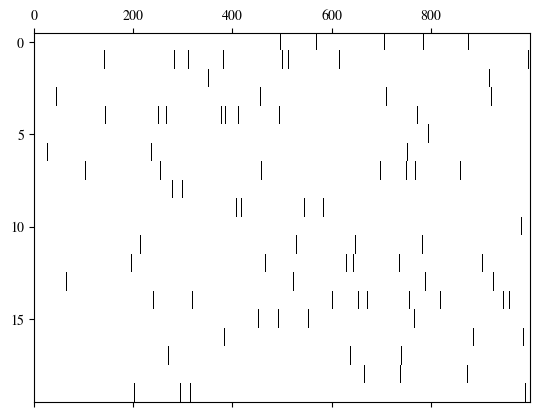

In [6]:
X = naive_res['RBOAA']['K1'][3].X
X_osm = naive_osm['TSAA']['K1'][3].X
X_cor = naive_cor['CAA']['K1'][3].X
plt.spy(X-X_cor, aspect = 'auto')

idx = np.nonzero(X-X_cor)

In [60]:

import torch
def _calculate_probRBOAA(Xt,X_hat,b,sigma):
        z_next = (torch.gather(b,1,Xt)-X_hat)/sigma#[:,None]
        z_prev = (torch.gather(b,1,Xt-1)-X_hat)/sigma #[:,None]
        z_next[Xt == len(b[0,:])+1] = np.inf
        z_prev[Xt == 1] = -np.inf
        P_next = torch.distributions.normal.Normal(0, 1).cdf(z_next)
        P_prev = torch.distributions.normal.Normal(0, 1).cdf(z_prev)
        return P_next- P_prev
        

def _calculate_probOAA(Xt, X_hat, b, sigma):
        z_next = (b[Xt] - X_hat)/sigma
        z_prev = (b[Xt-1] - X_hat)/sigma
        z_next[Xt == len(b)+1] = np.inf
        z_prev[Xt == 1] = -np.inf
        P_next = torch.distributions.normal.Normal(0, 1).cdf(z_next)
        P_prev = torch.distributions.normal.Normal(0, 1).cdf(z_prev)
        return P_next- P_prev

        
def findProb(data,method, i, j, p):
    
    X_hat = torch.tensor(data[method][f'K{i}'][j].X_hat)
    Prob = torch.zeros(X_hat.shape)
    b = torch.tensor(data[method][f'K{i}'][j].b)
    sigma = torch.tensor(data[method][f'K{i}'][j].sigma)
    R_est = torch.zeros(X.shape)

    sigma = torch.tensor(naive_cor['OAA'][f'K{i}'][j].sigma)
    sigmaRBOAA = torch.tensor(naive_cor['RBOAA'][f'K{i}'][j].sigma)

    betaOAA = torch.tensor(naive_cor['OAA'][f'K{i}'][j].b)
    betaRBOAA = torch.tensor(naive_cor['RBOAA'][f'K{i}'][j].b)

    sigma_test = sigma.repeat(sigmaRBOAA.shape)
    beta_test = betaOAA.repeat(betaRBOAA.shape)

    X_hat = torch.tensor(naive_cor['OAA'][f'K{i}'][j].X_hat)


    for l in p:
        Xt = torch.ones(X_hat.shape,dtype = int)*(int(l))

        if method == 'OAA':
            Prob = _calculate_probOAA(Xt, X_hat, b, sigma)

        elif method == 'RBOAA':
            Prob =  _calculate_probRBOAA(Xt,X_hat,beta_test,sigma_test.T)
                
        R_est += Prob*l


    return R_est






In [61]:
betaRBOAA

tensor([[-0.1376,  0.0782,  0.3135,  0.5239,  0.7016,  1.6716],
        [-0.1440,  0.1485,  0.3992,  0.6688,  0.8430,  1.7818],
        [-0.1632,  0.0404,  0.2107,  0.5962,  0.8541,  1.7348],
        ...,
        [-0.1101,  0.1131,  0.3433,  0.5866,  0.8005,  1.7398],
        [-0.1545,  0.0406,  0.2329,  0.5810,  0.6927,  1.6096],
        [-0.1537,  0.0319,  0.1543,  0.3022,  0.8830,  1.6858]])

In [62]:


beta_test

tensor([[-0.0959,  0.1322,  0.3436,  ...,  0.5588,  0.7852,  1.7372],
        [-0.0959,  0.1322,  0.3436,  ...,  0.5588,  0.7852,  1.7372],
        [-0.0959,  0.1322,  0.3436,  ...,  0.5588,  0.7852,  1.7372],
        ...,
        [-0.0959,  0.1322,  0.3436,  ...,  0.5588,  0.7852,  1.7372],
        [-0.0959,  0.1322,  0.3436,  ...,  0.5588,  0.7852,  1.7372],
        [-0.0959,  0.1322,  0.3436,  ...,  0.5588,  0.7852,  1.7372]])

In [63]:
p = [1,2,3,4,5]

R_corr_CAA = np.zeros((11,10),dtype= object)
R_corr_RBOAA = np.zeros((11,10),dtype= object)
R_corr_OAA = np.zeros((11,10),dtype= object)
R_corr_TSOAA = np.zeros((11,10),dtype= object)

for i in range(1,11): 
    for j in range(10):

        R_estRBOAA = findProb(naive_cor,'RBOAA', i, j, p)
        R_estOAA = findProb(naive_cor,'OAA', i, j, p)


        R_corr_CAA[i,j] = naive_cor['CAA']['K1'][3].X@naive_cor['CAA'][f'K{i}'][j].B@naive_cor['CAA'][f'K{i}'][j].A
        R_corr_OAA[i,j] = R_estOAA.numpy() #naive_cor['OAA']['K1'][3].X@naive_cor['OAA'][f'K{i}'][j].B@naive_cor['OAA'][f'K{i}'][j].A
        R_corr_RBOAA[i,j] = R_estRBOAA.numpy() #naive_cor['RBOAA']['K1'][3].X@naive_cor['RBOAA'][f'K{i}'][j].B@naive_cor['RBOAA'][f'K{i}'][j].A
        R_corr_TSOAA[i,j] = naive_cor['CAA']['K1'][3].X@naive_osm_corr['TSAA'][f'K{i}'][j].B@naive_osm_corr['TSAA'][f'K{i}'][j].A

In [64]:
X.shape

(20, 1000)

In [65]:
SSE_CAA = np.zeros((11,10))
SSE_RBOAA = np.zeros((11,10))
SSE_OAA = np.zeros((11,10))
SSE_TSOAA = np.zeros((11,10))

for i in range(1,11):
    for j in range(10):
        SSE_CAA[i,j] = np.sqrt(((X[idx]- R_corr_CAA[i,j][idx])**2).sum())/np.sqrt(len(idx[1]))
        SSE_OAA[i,j] = np.sqrt(((X[idx]- R_corr_OAA[i,j][idx])**2).sum())/np.sqrt(len(idx[1]))
        SSE_RBOAA[i,j] = np.sqrt(((X[idx]- R_corr_RBOAA[i,j][idx])**2).sum())/np.sqrt(len(idx[1]))
        SSE_TSOAA[i,j] = np.sqrt(((X[idx]- R_corr_TSOAA[i,j][idx])**2).sum())/np.sqrt(len(idx[1]))


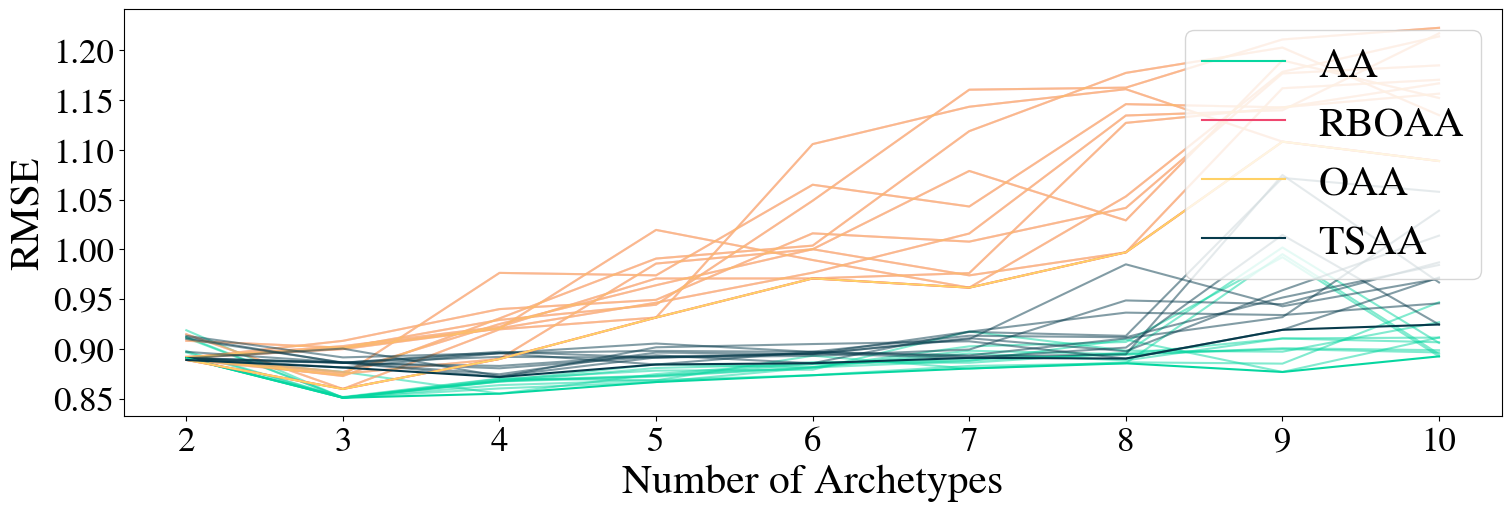

In [66]:
## Plot SSE

fig, ax = plt.subplots(1,1, figsize = (15,5), layout='constrained')
ax.plot(range(2,11), SSE_CAA[2:], c = my_pallette['AA'],alpha = 0.5)
ax.plot(range(2,11), SSE_RBOAA[2:],c = my_pallette['RBOAA'],alpha= 0.5)
ax.plot(range(2,11), SSE_OAA[2:],c = my_pallette['OAA'],alpha= 0.5)
ax.plot(range(2,11), SSE_TSOAA[2:],c = my_pallette['TSOAA'],alpha = 0.5)

ax.plot(range(2,11), np.min(SSE_CAA[2:],axis = 1), c = my_pallette['AA'],label = 'AA')
ax.plot(range(2,11), np.min(SSE_RBOAA[2:],axis = 1),c =  my_pallette['RBOAA'],label = 'RBOAA')
ax.plot(range(2,11), np.min(SSE_OAA[2:],axis = 1),c =  my_pallette['OAA'],label = 'OAA')
ax.plot(range(2,11), np.min(SSE_TSOAA[2:],axis = 1),c =  my_pallette['TSOAA'],label = 'TSAA')


ax.set_xlabel("Number of Archetypes", fontsize = 30)
ax.set_ylabel("RMSE", fontsize = 30)

plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.legend(loc='upper right',fontsize = 30)

plt.savefig("Plots_for_paper/CorruptionError_naive.png",dpi=1000)



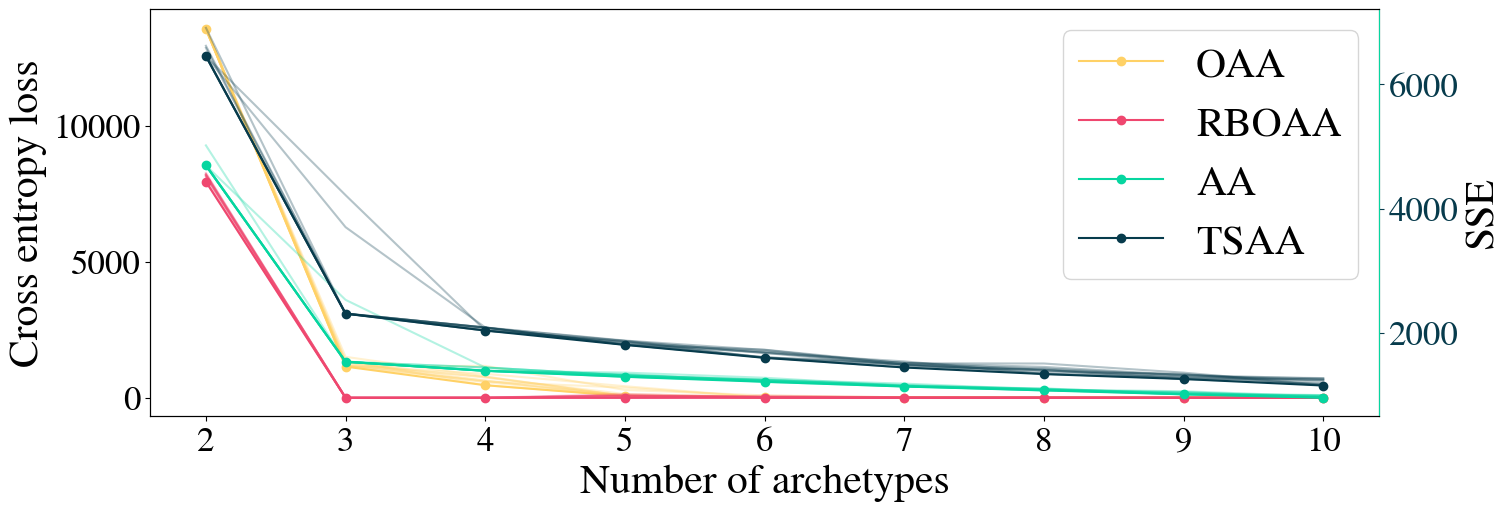

In [11]:
K_list = np.arange(2,11)
loss_archetype_plot(K_list,results_path = 'C:/Users/aejew/Downloads/AA_results/AA_results/1000_respondents_noRB_results/all_AA_results.json',results_path2 = 'C:/Users/aejew/Downloads/AA_results/AA_results/no_RB_OSM/all_AA_results.json')

plt.savefig("Plots_for_paper/Error_K_naive.png",dpi=1000)

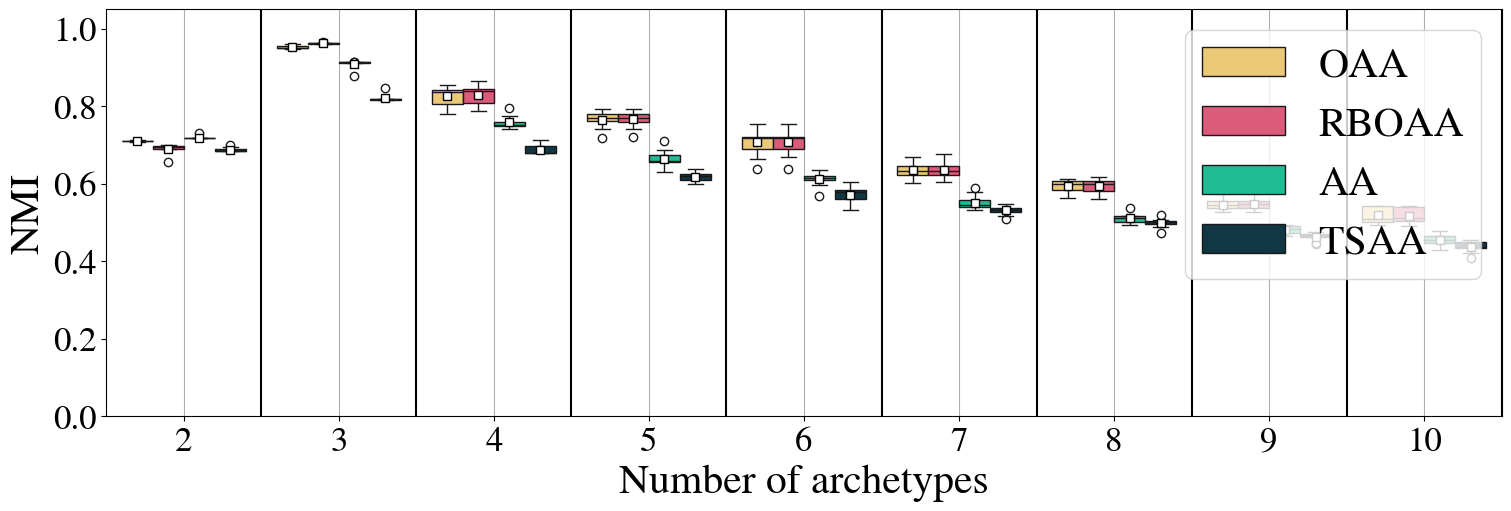

In [12]:
K_list = np.arange(2,11)
NMI_archetypes(K_list,results_path = 'C:/Users/aejew/Downloads/AA_results/AA_results/1000_respondents_noRB_results/all_AA_results.json',results_path2 = 'C:/Users/aejew/Downloads/AA_results/AA_results/no_RB_OSM/all_AA_results.json')

plt.savefig("Plots_for_paper/NMI_K_naive.png",dpi=1000)

# Complex Data

In [26]:
complex_res= load_analyses("complex_results")
complex_cor = load_analyses("complex_corrupted_results")
complex_osm = load_analyses("complex_OSM_results")
complex_osm_corr = load_analyses("complex_OSM_corrupted_results")

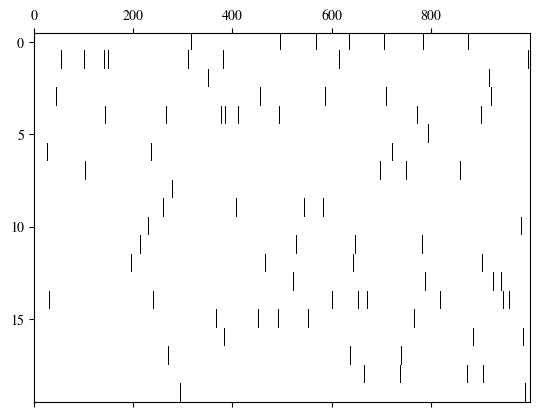

In [14]:
X = complex_res['RBOAA']['K1'][2].X
X_osm = complex_osm['TSAA']['K1'][3].X
X_cor = complex_cor['CAA']['K1'][3].X
plt.spy(X-X_cor, aspect = 'auto')

idx = np.nonzero(X-X_cor)



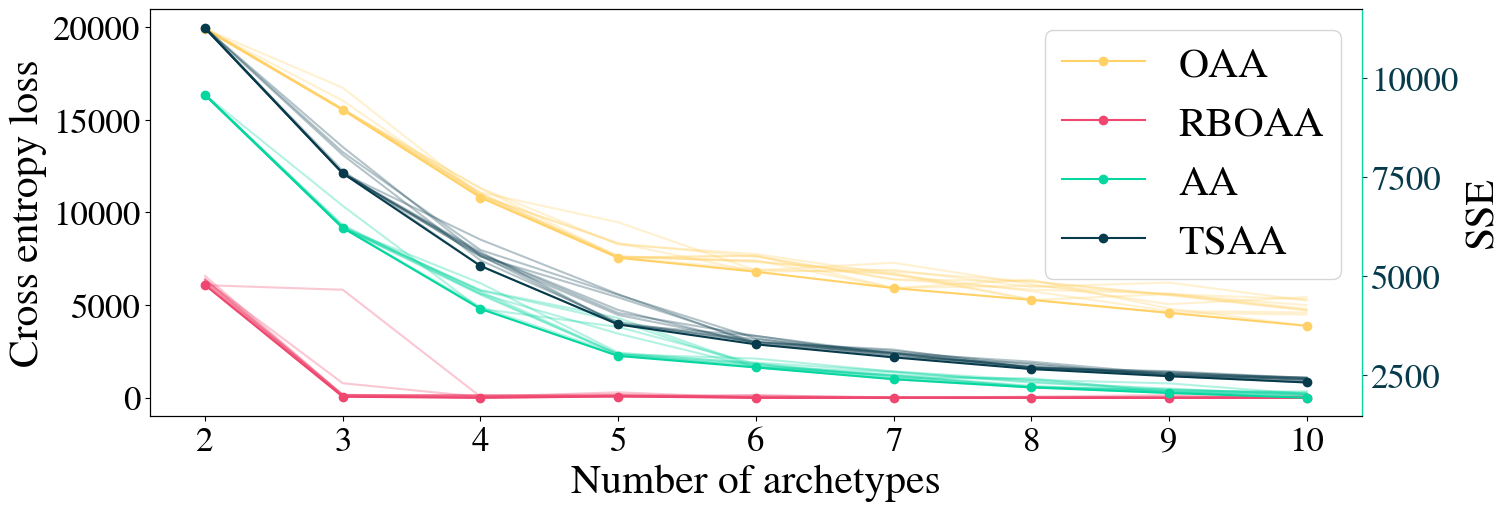

In [16]:
K_list = np.arange(2,11)
loss_archetype_plot(K_list,results_path = 'C:/Users/aejew/Downloads/AA_results/AA_results/complex_results/all_AA_results.json',results_path2 = 'C:/Users/aejew/Downloads/AA_results/AA_results/complex_OSM_results/all_AA_results.json')

plt.savefig("Plots_for_paper/Error_K_complex.png",dpi=1000)

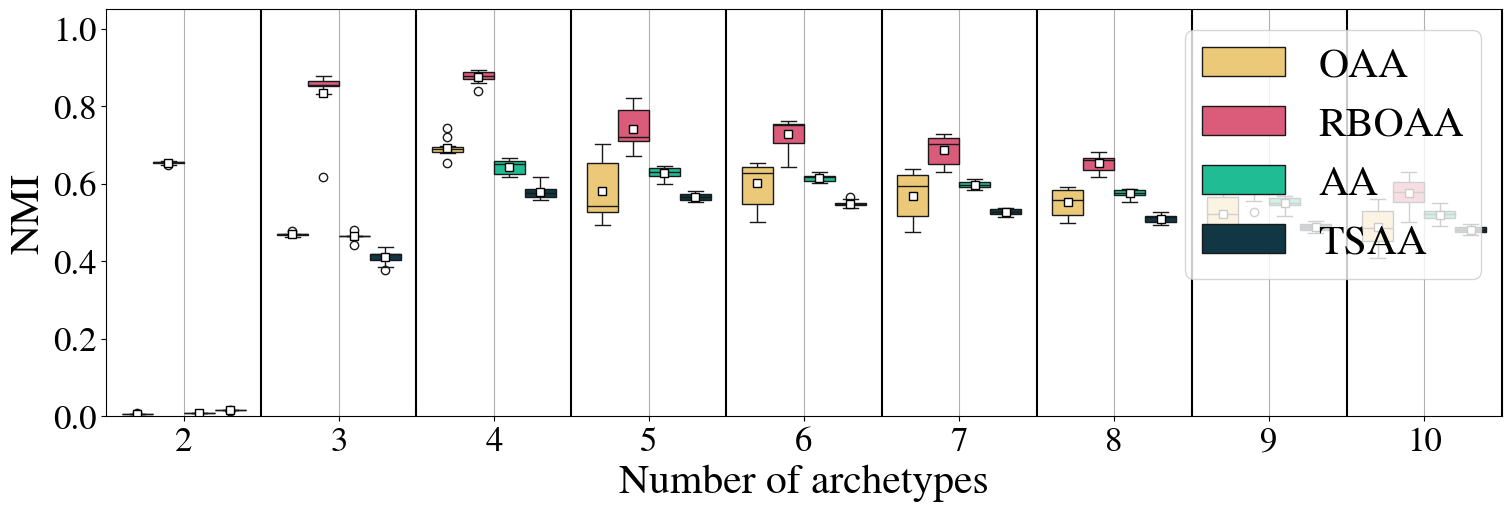

In [17]:
K_list = np.arange(2,11)
NMI_archetypes(K_list,results_path = 'C:/Users/aejew/Downloads/AA_results/AA_results/complex_results/all_AA_results.json',results_path2 = 'C:/Users/aejew/Downloads/AA_results/AA_results/complex_OSM_results/all_AA_results.json')

plt.savefig("Plots_for_paper/NMI_K_complex.png",dpi=1000)

In [22]:

import torch
def _calculate_probRBOAA(Xt,X_hat,b,sigma):
        z_next = (torch.gather(b,1,Xt)-X_hat)/sigma#[:,None]
        z_prev = (torch.gather(b,1,Xt-1)-X_hat)/sigma #[:,None]
        z_next[Xt == len(b[0,:])+1] = np.inf
        z_prev[Xt == 1] = -np.inf
        P_next = torch.distributions.normal.Normal(0, 1).cdf(z_next)
        P_prev = torch.distributions.normal.Normal(0, 1).cdf(z_prev)
        return P_next- P_prev
        

def _calculate_probOAA(Xt, X_hat, b, sigma):
        z_next = (b[Xt] - X_hat)/sigma
        z_prev = (b[Xt-1] - X_hat)/sigma
        z_next[Xt == len(b)+1] = np.inf
        z_prev[Xt == 1] = -np.inf
        P_next = torch.distributions.normal.Normal(0, 1).cdf(z_next)
        P_prev = torch.distributions.normal.Normal(0, 1).cdf(z_prev)
        return P_next- P_prev

        
def findProb(data,method, i, j, p):
    
    X_hat = torch.tensor(data[method][f'K{i}'][j].X_hat)
    Prob = torch.zeros(X_hat.shape)
    b = torch.tensor(data[method][f'K{i}'][j].b)
    sigma = torch.tensor(data[method][f'K{i}'][j].sigma)
    R_est = torch.zeros(X.shape)

    for l in p:
        Xt = torch.ones(X_hat.shape,dtype = int)*(int(l))

        if method == 'OAA':
            Prob = _calculate_probOAA(Xt, X_hat, b, sigma)

        elif method == 'RBOAA':
            Prob =  _calculate_probRBOAA(Xt,X_hat,b,sigma.T)
                
        R_est += Prob*l


    return R_est






In [23]:
p = [1,2,3,4,5]

R_corr_CAA = np.zeros((11,10),dtype= object)
R_corr_RBOAA = np.zeros((11,10),dtype= object)
R_corr_OAA = np.zeros((11,10),dtype= object)
R_corr_TSOAA = np.zeros((11,10),dtype= object)


for i in range(1,11): 
    for j in range(10):
        R_estRBOAA = findProb(complex_cor,'RBOAA', i, j, p)
        R_estOAA = findProb(complex_cor,'OAA', i, j, p)

        R_corr_CAA[i,j] = complex_cor['CAA']['K1'][3].X@complex_cor['CAA'][f'K{i}'][j].B@complex_cor['CAA'][f'K{i}'][j].A
        R_corr_OAA[i,j] = R_estOAA.numpy() # complex_cor['OAA']['K1'][3].X@complex_cor['OAA'][f'K{i}'][j].B@complex_cor['OAA'][f'K{i}'][j].A
        R_corr_RBOAA[i,j] = R_estRBOAA.numpy() # complex_cor['RBOAA']['K1'][3].X@complex_cor['RBOAA'][f'K{i}'][j].B@complex_cor['RBOAA'][f'K{i}'][j].A
        R_corr_TSOAA[i,j] = complex_cor['CAA']['K1'][3].X@complex_osm_corr['TSAA'][f'K{i}'][j].B@complex_osm_corr['TSAA'][f'K{i}'][j].A

        


In [24]:
SSE_CAA = np.zeros((11,10))
SSE_RBOAA = np.zeros((11,10))
SSE_OAA = np.zeros((11,10))
SSE_TSOAA = np.zeros((11,10))

for i in range(1,11):
    for j in range(10):
        SSE_CAA[i,j] = np.sqrt(((X[idx]- R_corr_CAA[i,j][idx])**2).sum())/np.sqrt(len(idx[1]))
        SSE_OAA[i,j] = np.sqrt(((X[idx]- R_corr_OAA[i,j][idx])**2).sum())/np.sqrt(len(idx[1]))
        SSE_RBOAA[i,j] = np.sqrt(((X[idx]- R_corr_RBOAA[i,j][idx])**2).sum())/np.sqrt(len(idx[1]))
        SSE_TSOAA[i,j] = np.sqrt(((X[idx]- R_corr_TSOAA[i,j][idx])**2).sum())/np.sqrt(len(idx[1]))

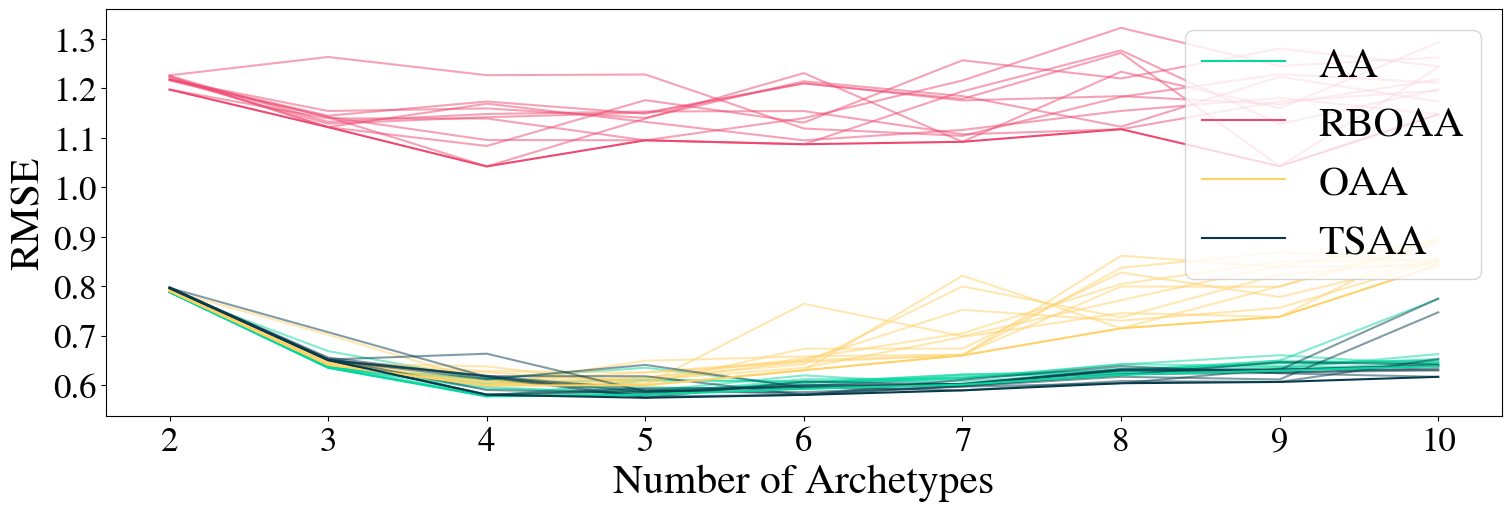

In [25]:
## Plot SSE

fig, ax = plt.subplots(1,1, figsize = (15,5), layout='constrained')
ax.plot(range(2,11), SSE_CAA[2:], c = my_pallette['AA'],alpha = 0.5)
ax.plot(range(2,11), SSE_RBOAA[2:],c = my_pallette['RBOAA'],alpha= 0.5)
ax.plot(range(2,11), SSE_OAA[2:],c = my_pallette['OAA'],alpha= 0.5)
ax.plot(range(2,11), SSE_TSOAA[2:],c = my_pallette['TSOAA'],alpha = 0.5)

ax.plot(range(2,11), np.min(SSE_CAA[2:],axis = 1), c = my_pallette['AA'],label = 'AA')
ax.plot(range(2,11), np.min(SSE_RBOAA[2:],axis = 1),c =  my_pallette['RBOAA'],label = 'RBOAA')
ax.plot(range(2,11), np.min(SSE_OAA[2:],axis = 1),c =  my_pallette['OAA'],label = 'OAA')
ax.plot(range(2,11), np.min(SSE_TSOAA[2:],axis = 1),c =  my_pallette['TSOAA'],label = 'TSAA')


ax.set_xlabel("Number of Archetypes", fontsize = 30)
ax.set_ylabel("RMSE", fontsize = 30)

plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.legend(loc='upper right',fontsize = 30)

plt.savefig("Plots_for_paper/CorruptionError_complex.png",dpi=1000)

In [32]:
complex_res['RBOAA']['K4'][2].b

array([[-0.5643508 ,  0.1351816 ,  0.2899152 ,  0.6889921 ,  0.75779086,
         1.5507133 ],
       [-0.4954187 ,  0.23114982,  0.5761889 ,  0.89950013,  0.95378304,
         1.648343  ],
       [-0.60297537, -0.00773185,  0.11433423,  0.4715097 ,  0.76945245,
         1.4797649 ],
       ...,
       [-0.4183469 ,  0.45807722,  0.7286905 ,  0.8393074 ,  0.968065  ,
         1.6877363 ],
       [-0.5064369 ,  0.2301035 ,  0.4448132 ,  0.8343863 ,  0.8730162 ,
         1.5979884 ],
       [-0.5497524 ,  0.13674825,  0.27758664,  0.3427639 ,  0.77268964,
         1.5396864 ]], dtype=float32)

In [28]:
np.load("SyntheticData/1000_respondents_complex\X_large_complex.npy")

array([[5, 2, 5, ..., 2, 5, 5],
       [2, 2, 2, ..., 1, 1, 2],
       [5, 2, 5, ..., 1, 4, 4],
       ...,
       [5, 3, 5, ..., 4, 5, 5],
       [3, 2, 4, ..., 2, 4, 3],
       [2, 1, 3, ..., 1, 1, 3]], dtype=int64)